In [1]:
import gshap
import numpy as np
import pandas as pd
import seaborn as sns
from gshap.datasets import load_recidivism
from gshap.intergroup import IntergroupDifference
from scipy.stats import ttest_ind
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tpot import TPOTClassifier

import pickle
import random

random.seed(0)
np.random.seed(0)

/home/dsbowen/algorithm-fairness/venv/lib/python3.6/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
recidivism = load_recidivism()
X, y = recidivism.data, recidivism.target
X = X.drop(columns='high_supervision')
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_train_black = y_train[X_train['black']==1]
y_train_white = y_train[X_train['black']==0]
y_test_black = y_test[X_test['black']==1]
y_test_white = y_test[X_test['black']==0]

In [3]:
# run this cell to fit the TPOT classifier
# it will take several hours

# optim = TPOTClassifier(verbosity=2)
# optim.fit(X_train, y_train)
# optim.export('pipeline.py')

In [4]:
# this is the pipeline recommended by TPOT

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

clf = make_pipeline(
    StackingEstimator(estimator=MultinomialNB(alpha=10.0, fit_prior=True)),
    StackingEstimator(estimator=MultinomialNB(alpha=0.001, fit_prior=True)),
    RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.9500000000000001, min_samples_leaf=17, min_samples_split=11, n_estimators=100)
)
clf.fit(X_train, y_train)
# save model
with open('../survey/clf.p', 'wb') as f:
    pickle.dump(clf, f)

In [5]:
# save summary dataframe
df = X_train.copy()
df['two_year_recid'] = y_train
df['juv_offenses'] = df[['juv_fel_count', 'juv_misd_count', 'juv_other_count']].sum(axis=1)
df.describe().to_csv('../survey/summary.csv')

In [6]:
class Model():
    def __init__(self, clf, X, exp=1):
        self.clf = clf
        self.black_idx = list(X.columns).index('black')
        self.exp = exp

    def predict_proba(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        black = X[:, self.black_idx]
        output = self.clf.predict_proba(X)[:,1]
        return (
            (1-black)*(2*output-output**self.exp) 
            + black*output**self.exp
        )

#     def predict_proba(self, X):
#         X = X.values if isinstance(X, pd.DataFrame) else X
#         black = X[:, self.black_idx]
#         output = self.clf.predict_proba(X)[:,1]
#         return (
#             black*(
#                (output < .5+self.t)*output*.5/(.5+self.t)
#                + (output >= .5+self.t)*(1-(1-output)*.5/(.5-self.t)) 
#             )
#             + (1-black)*(
#                 (output < .5-self.t)*output*.5/(.5-self.t)
#                 + (output >= .5-self.t)*(1-(1-output)*.5/(.5+self.t))
#             )
#         )

    def predict(self, X):
        return self.predict_proba(X) > .5

In [7]:
class Metrics():
    def __init__(self, clf, X, y):
        self.clf, self.X, self.y = clf, X, y
        self.white = X['black']==0
        self.black = X['black']==1
        self.y_white = y[self.white]
        self.y_black = y[self.black]
        self.compute_output()
        
    def compute_output(self):
        self.output = self.clf.predict_proba(self.X)
        self.y_pred = self.output > .5
        self.output_white = self.output[self.white]
        self.y_pred_white = self.y_pred[self.white]
        self.output_black = self.output[self.black]
        self.y_pred_black = self.y_pred[self.black]
        self.y_fp_white = self.y_pred_white[self.y_white==0]
        self.output_fp_white = self.output_white[self.y_white==0]
        self.y_fp_black = self.y_pred_black[self.y_black==0]
        self.output_fp_black = self.output_black[self.y_black==0]
        
    def report(self):
        y, y_pred = self.y, self.y_pred
        y_black, y_pred_black = self.y_black, self.y_pred_black
        y_white, y_pred_white = self.y_white, self.y_pred_white
        print('Overall accuracy: %.4f' % accuracy_score(y, y_pred))
        print('Accuracy for Blacks: %.4f' % accuracy_score(y_black, y_pred_black))
        print('Accuracy for Whites: %.4f' % accuracy_score(y_white, y_pred_white))
        fpr, tpr, thresholds = metrics.roc_curve(y, self.output)
        print('AUC: %.4f' % metrics.auc(fpr, tpr))
        print('\nConfusion matrix for Blacks')
        print(confusion_matrix(y_black, y_pred_black, normalize='true'))
        print('\nConfusion matrix for Whites')
        print(confusion_matrix(y_white, y_pred_white, normalize='true'))
#         fp_diff_ = fp_diff(y_pred_white, y_pred_black, y_white, y_black)
        print('\nRisk for Whites who did not recidivate: %.4f' % self.output_fp_white.mean())
        print('Risk for Blacks who did not recidivate: %.4f' % self.output_fp_black.mean())
        fp_diff_ = fp_diff(self.output_white, self.output_black, y_white, y_black)
        print('Difference in false positive predictions: %.4f' % fp_diff_)
        print('p=%.4f' % ttest_ind(self.output_fp_white, self.output_fp_black, equal_var=False)[1])
        

def fp_diff(y_pred_white, y_pred_black, y_white=y_test_white, y_black=y_test_black):
    fp_black = confusion_matrix(y_black, y_pred_black, normalize='true')[0,1]
    fp_white = confusion_matrix(y_white, y_pred_white, normalize='true')[0,1]
    return fp_black / fp_white - 1

def fp_diff(output_white, output_black, y_white=y_train_white, y_black=y_train_black):
    output_white = output_white[y_white==0]
    output_black = output_black[y_black==0]
    return output_black.mean() / output_white.mean() - 1

model = Model(clf, X)
Metrics(model, X_train, y_train).report()

Overall accuracy: 0.7219
Accuracy for Blacks: 0.7271
Accuracy for Whites: 0.7154
AUC: 0.8075

Confusion matrix for Blacks
[[0.63022222 0.36977778]
 [0.20169713 0.79830287]]

Confusion matrix for Whites
[[0.78249788 0.21750212]
 [0.3648374  0.6351626 ]]

Risk for Whites who did not recidivate: 0.3591
Risk for Blacks who did not recidivate: 0.4428
Difference in false positive predictions: 0.2330
p=0.0000


[0.00098634 0.06185528 0.00324327 0.00494016 0.00049028 0.10015736
 0.01339489 0.04964898 0.00801046] 0.24272701144780573


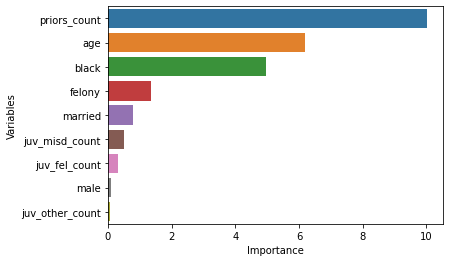

In [8]:
g = IntergroupDifference(group=X_train['black'], distance=fp_diff)
explainer = gshap.KernelExplainer(model.predict_proba, X_train, g)
gshap_values = explainer.gshap_values(X_train, nsamples=32)
df = pd.DataFrame({'Variables': X.columns, 'Importance': 100*gshap_values})
df = df.sort_values('Importance', ascending=False)
fig = sns.barplot(y='Variables', x='Importance', data=df)
fig.figure.savefig('figures/original_model_gshap.png', bbox_inches = "tight")
print(gshap_values, gshap_values.sum())

In [9]:
fp_diff_ = np.inf
while fp_diff_ > 0:
    prev_fp_diff_ = fp_diff_
    model.exp += .01
    print('\nModel exponent: %.2f' % model.exp)
    output = model.predict_proba(X_train)
    output_white = output[X_train.black == 0]
    output_black = output[X_train.black == 1]
    fp_diff_ = fp_diff(output_white, output_black, y_train_white, y_train_black)
    print('Difference in risk scores: %.4f' % fp_diff_)
    
if abs(fp_diff_) > abs(prev_fp_diff_):
    model.t -= .01
   
print('\nFinal exponent: %.2f' % model.exp)
Metrics(model, X_train, y_train).report()


Model exponent: 1.01
Difference in risk scores: 0.2130

Model exponent: 1.02
Difference in risk scores: 0.1936

Model exponent: 1.03
Difference in risk scores: 0.1747

Model exponent: 1.04
Difference in risk scores: 0.1564

Model exponent: 1.05
Difference in risk scores: 0.1385

Model exponent: 1.06
Difference in risk scores: 0.1211

Model exponent: 1.07
Difference in risk scores: 0.1041

Model exponent: 1.08
Difference in risk scores: 0.0876

Model exponent: 1.09
Difference in risk scores: 0.0715

Model exponent: 1.10
Difference in risk scores: 0.0559

Model exponent: 1.11
Difference in risk scores: 0.0406

Model exponent: 1.12
Difference in risk scores: 0.0257

Model exponent: 1.13
Difference in risk scores: 0.0111

Model exponent: 1.14
Difference in risk scores: -0.0031

Final exponent: 1.14
Overall accuracy: 0.7227
Accuracy for Blacks: 0.7268
Accuracy for Whites: 0.7177
AUC: 0.8044

Confusion matrix for Blacks
[[0.65155556 0.34844444]
 [0.21801567 0.78198433]]

Confusion matrix fo

[-0.00051652  0.03376798  0.00350941  0.00483793 -0.0022564   0.06619675
  0.00855001 -0.13534027  0.00724317] -0.014007947028183969


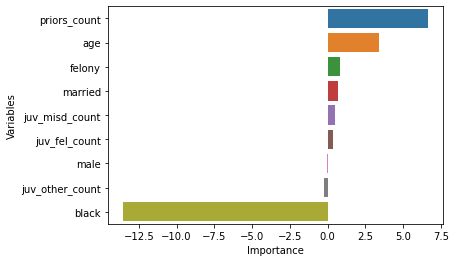

In [10]:
g = IntergroupDifference(group=X_train['black'], distance=fp_diff)
explainer = gshap.KernelExplainer(model.predict_proba, X_train, g)
gshap_values = explainer.gshap_values(X_train, nsamples=32)
df = pd.DataFrame({'Variables': X.columns, 'Importance': 100*gshap_values})
df = df.sort_values('Importance', ascending=False)
fig = sns.barplot(y='Variables', x='Importance', data=df)
fig.figure.savefig('figures/adjusted_model_gshap.png', bbox_inches = "tight")
print(gshap_values, gshap_values.sum())

In [11]:
def fp_diff(output_white, output_black, y_white=y_test_white, y_black=y_test_black):
    output_white = output_white[y_white==0]
    output_black = output_black[y_black==0]
    return output_black.mean() / output_white.mean() - 1

Metrics(model, X_test, y_test).report()

Overall accuracy: 0.6731
Accuracy for Blacks: 0.6872
Accuracy for Whites: 0.6547
AUC: 0.7314

Confusion matrix for Blacks
[[0.58673469 0.41326531]
 [0.23643411 0.76356589]]

Confusion matrix for Whites
[[0.67546174 0.32453826]
 [0.36990596 0.63009404]]

Risk for Whites who did not recidivate: 0.4253
Risk for Blacks who did not recidivate: 0.4351
Difference in false positive predictions: 0.0231
p=0.4847


In [12]:
model = Model(clf, X)
Metrics(model, X_test, y_test).report()

Overall accuracy: 0.6681
Accuracy for Blacks: 0.6806
Accuracy for Whites: 0.6519
AUC: 0.7349

Confusion matrix for Blacks
[[0.55357143 0.44642857]
 [0.22286822 0.77713178]]

Confusion matrix for Whites
[[0.71503958 0.28496042]
 [0.42319749 0.57680251]]

Risk for Whites who did not recidivate: 0.3837
Risk for Blacks who did not recidivate: 0.4762
Difference in false positive predictions: 0.2412
p=0.0000


In [13]:
X_test.head()

,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,felony,black,married
1916,0,35,0,0,0,2,1,1,0
1096,1,24,0,0,0,1,1,0,0
2894,1,26,0,1,3,14,1,1,0
733,1,30,0,0,0,1,1,0,0
2210,1,29,0,2,0,12,1,1,0


In [14]:
y_test.head()

1916    0
1096    1
2894    1
733     1
2210    1
Name: two_year_recid, dtype: int64

[-1.46797949e-02 -1.28405961e-01  9.52563828e-05 -3.88166464e-03
 -4.49941273e-03  2.24729129e-02  1.89616267e-02  6.50924473e-04
  7.89920435e-03] -0.10138690792757021


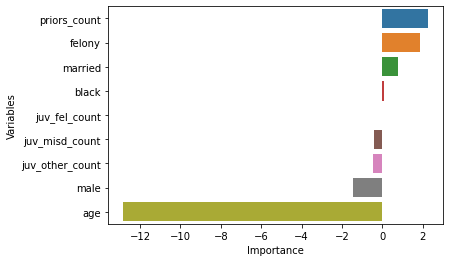

In [15]:
x = X_test.values[0].reshape(1, -1)
explainer = gshap.KernelExplainer(model.predict_proba, X_train)
gshap_values = explainer.gshap_values(x, nsamples=100)
df = pd.DataFrame({'Variables': X.columns, 'Importance': 100*gshap_values})
df = df.sort_values('Importance', ascending=False)
ax = sns.barplot(y='Variables', x='Importance', data=df)
ax.figure.savefig('figures/example_SHAP.png', bbox_inches = "tight")
print(gshap_values, gshap_values.sum())

In [16]:
explainer.compare(x)

(0.3551544940727163, 0.5290176273525814)